In [1]:
# Parameters to set to run this notebook

# Initialize helpers.
import numpy as np
import project_path
from model.data_accessor import get_data_file_abs_path
from model.neuron_metadata import *
neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json(get_data_file_abs_path('chem.json'))
N = neuron_metadata_collection.get_size()

# How many seconds to run each step for. This should be long enough for stability to be observed.
step_duration_s = 4
# The step amplitudes in nA. Each amplitude will be run for step_duration
start_amp_nA = 0.5
peak_amp_nA = 1.5
amp_delta_nA = 0.1
step_amplitudes_nA = np.concatenate((np.arange(start_amp_nA, peak_amp_nA, amp_delta_nA), \
                                     np.arange(peak_amp_nA, start_amp_nA-amp_delta_nA/2, -amp_delta_nA)), axis=None)

neurons_to_stimulate = ["AWAR"]

# Initial condition
# If you want a fixed-seed initial condition, uncomment the line below.
# np.random.seed(0)
init_conds = 10**(-4)*np.random.normal(0, 0.94, 2*N)


In [2]:
# Setup the model
from model.neural_model import NeuralModel
from util.plot_util import *
import os
import pickle

neurons_to_observe = NeuronMetadataCollection.create_lr_names_from_base([
  "AWA"
])
model = NeuralModel(neuron_metadata_collection)
model.init_conds = init_conds

# Set I_inj_i(t)

def time_to_I_ext_fun(t):
  amp = step_amplitudes_nA[int(t / step_duration_s)]
  cur_I_ext = np.zeros(N)
  for neuron in neurons_to_stimulate:
    neuron_id = neuron_metadata_collection.get_id_from_name(neuron)
    cur_I_ext[neuron_id] = amp
  return cur_I_ext

# These are timesteps when I_ext changes
num_step_values = len(step_amplitudes_nA)
t_changes_I_ext = np.array(range(num_step_values)) * step_duration_s
t_changes_I_ext = t_changes_I_ext.tolist()
model.set_I_ext(time_to_I_ext_fun, t_changes_I_ext)

model.init_kunert_2017()

step_duration_timesteps = int(step_duration_s / model.dt)
simul_timesteps = step_duration_timesteps * len(step_amplitudes_nA)

In [3]:
# Run the model. Or not, if cached result already exists
# Cache file is about ~1MB for 1 second.
cache_key = "%d_%.2f_%.2f_%.2f_%s" % \
  (step_duration_s, start_amp_nA, peak_amp_nA, amp_delta_nA, "_".join(neurons_to_stimulate))
cache_path = "../local_results/exp_CHANGING_STEP_AWA/" + cache_key

v_normalized_mat = []
if os.path.isfile(cache_path):
  print("Loading saved results from pickle file {}".format(cache_path))
  with open(cache_path, "rb") as f:
    (v_mat, v_normalized_mat) = pickle.load(f)
else:
  (v_mat, s_mat, v_normalized_mat) = model.run(simul_timesteps)
  # Update cache
  with open(cache_path, "wb") as f:
    pickle.dump((v_mat, v_normalized_mat), f)

Loading saved results from pickle file ../local_results/exp_CHANGING_STEP_AWA/4_0.50_1.50_0.10_AWAR


# Plot stimulus

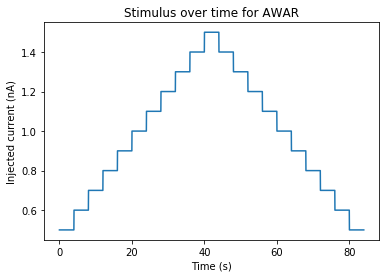

In [4]:
times = np.array(np.arange(0, simul_timesteps * model.dt, model.dt))

awal_index = neuron_metadata_collection.get_id_from_name("AWAR")
amps = [time_to_I_ext_fun(time)[awal_index] for time in times]
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(times, amps)
ax.set_title("Stimulus over time for AWAR")
ax.set_ylabel("Injected current (nA)")
ax.set_xlabel("Time (s)")
_ = _

# Plot potentials of selected neurons

In [5]:
#%matplotlib notebook
fig = plot_potentials(
  neuron_names_to_show = neurons_to_observe,
  dynamics = v_mat,
  is_normalized_v = False,
  dt = model.dt,
  neuron_metadata_collection = neuron_metadata_collection)
fig.show()

SyntaxError: positional argument follows keyword argument (<ipython-input-5-eaf1241ba5ea>, line 5)

In [ ]:
fig = plot_potentials(
  neuron_names_to_show = neurons_to_observe,
  dynamics = v_normalized_mat,
  is_normalized_v = True,
  dt = model.dt,
  neuron_metadata_collection = neuron_metadata_collection)
fig.show()

# Plot summarized dynamics per neuron class

In [ ]:
plot_pcas(v_normalized_mat, model.dt, neuron_metadata_collection)

# Bifurcation plot

In [ ]:
create_changing_step_bifurcation_plot(
    neurons_to_observe = neurons_to_observe,
    dynamics = v_normalized_mat,
    is_normalized_v = True,
    step_amps_nA = step_amplitudes_nA,
    start_amp_nA = start_amp_nA,
    peak_amp_nA = peak_amp_nA,
    amp_delta_nA = amp_delta_nA, 
    step_duration_timesteps = step_duration_timesteps,
    neuron_metadata_collection = neuron_metadata_collection)

In [ ]:
create_changing_step_bifurcation_plot(
    neurons_to_observe = neurons_to_observe,
    dynamics = v_mat,
    is_normalized_v = False,
    step_amps_nA = step_amplitudes_nA,
    start_amp_nA = start_amp_nA,
    peak_amp_nA = peak_amp_nA,
    amp_delta_nA = amp_delta_nA, 
    step_duration_timesteps = step_duration_timesteps,
    neuron_metadata_collection = neuron_metadata_collection)